## Prediction of flower's class

The aim of this task was to predict flower's class using Inception_V3 model. Transfer learning technique has been applied. In this project only target layer has been modified, other layers was retained. Model has been verified using early stopping. 

In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

from skimage import color, exposure
from skimage.transform import resize
from scipy.misc import imresize
from imgaug import augmenters as iaa
from imgaug import parameters as iap

import os
import sys
import tarfile
from six.moves import urllib
from collections import defaultdict
from random import sample
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

#### Downloading Inception model

In [2]:
TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("data", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rdownload: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [3]:
#fetch_pretrained_inception_v3()

#### Downloading data

In [3]:
FLOWERS_URL = "http://download.tensorflow.org/example_images/flower_photos.tgz"
FLOWERS_PATH = os.path.join("dataset", "flowers")

def fetch_flowers(url=FLOWERS_URL, path=FLOWERS_PATH):
    if os.path.exists(FLOWERS_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "flower_photos.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    flowers_tgz = tarfile.open(tgz_path)
    flowers_tgz.extractall(path=path)
    flowers_tgz.close()
    os.remove(tgz_path)

In [5]:
#fetch_flowers()

#### Data preparation

In [4]:
flowers_root_path = os.path.join(FLOWERS_PATH, "flower_photos")
flower_classes = sorted([dirname for dirname in os.listdir(flowers_root_path)
                 if os.path.isdir(os.path.join(flowers_root_path, dirname))])
flower_class_ids = {flower_class: index for index, flower_class in enumerate(flower_classes)}
flower_class_ids

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [5]:
image_paths = defaultdict(list)

for flower_class in flower_classes:
    image_dir = os.path.join(flowers_root_path, flower_class)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".jpg"):
            image_paths[flower_class].append(os.path.join(image_dir, filepath))
for paths in image_paths.values():
    paths.sort()    

In [6]:
flower_paths_and_classes = []
for flower_class, paths in image_paths.items():
    for path in paths:
        flower_paths_and_classes.append((path, flower_class_ids[flower_class]))

In [7]:
test_ratio = 0.2
train_size = int(len(flower_paths_and_classes) * (1 - test_ratio))

np.random.shuffle(flower_paths_and_classes)
flower_paths_and_classes_train = flower_paths_and_classes[:train_size]
flower_paths_and_classes_test = flower_paths_and_classes[train_size:]

In [8]:
flower_paths_and_classes_train[:5]

[('dataset/flowers/flower_photos/daisy/2476937534_21b285aa46_n.jpg', 0),
 ('dataset/flowers/flower_photos/roses/14970973709_968910640e_n.jpg', 2),
 ('dataset/flowers/flower_photos/roses/2960709681_e95940c0f0_n.jpg', 2),
 ('dataset/flowers/flower_photos/tulips/14066056226_d8564a083e_m.jpg', 4),
 ('dataset/flowers/flower_photos/tulips/9444202147_405290415b_n.jpg', 4)]

In [9]:
width = 299
height = 299
channels = 3

Class: daisy


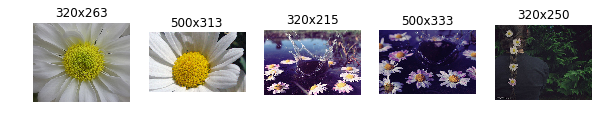

Class: dandelion


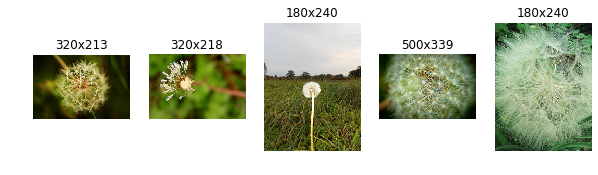

Class: roses


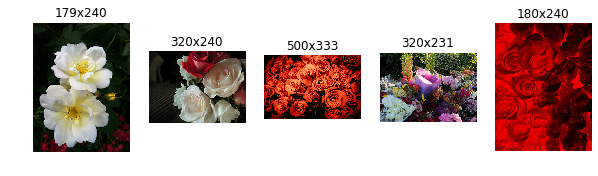

Class: sunflowers


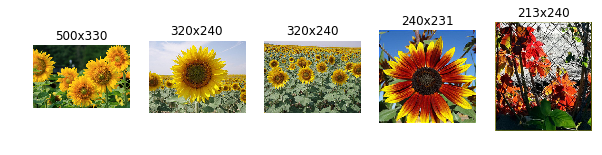

Class: tulips


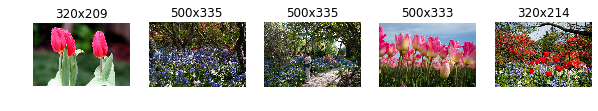

In [13]:
for flower_class in flower_classes:
    print("Class:", flower_class)
    plt.figure(figsize=(10,6))
    for index, example_image_path in enumerate(image_paths[flower_class][:5]):
        example_image = mpimg.imread(example_image_path)[:, :, :channels]
        plt.subplot(100 + 5 * 10 + index + 1)
        plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
        plt.imshow(example_image)
        plt.axis("off")
    plt.show()

The different size, quality and huge diversity are causing that task might be challenging.
In order to minimalize impact of this factors function for image preparation has been built. This function resizing images, cropping dimensions and adding gaussian blur. 

In [10]:
def prepare_image(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height
        
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    image = image[y0:y1, x0:x1]
    image = imresize(image, (target_width, target_height))
    
    blurer=iaa.GaussianBlur(iap.Uniform(0.1,2))
    image=blurer.augment_image(image)
    return image.astype(np.float32) / 255

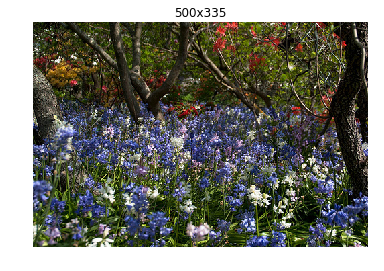

In [15]:
example_image = mpimg.imread(paths[1])[:, :, :channels]
plt.figure(figsize=(6, 8))
plt.imshow(example_image)
plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
plt.axis("off")
plt.show()

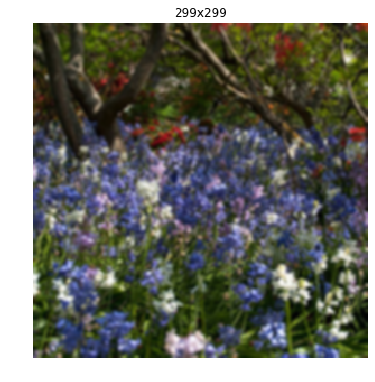

In [16]:
prepared_image = prepare_image(example_image)

plt.figure(figsize=(6, 8))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

### Model preparation and learning

In [11]:
def prepare_batch(flower_paths_and_classes, batch_size):    
    batch_paths_and_classes = sample(flower_paths_and_classes, batch_size)  
    images = [mpimg.imread(path)[:, :, :channels] for path, labels in batch_paths_and_classes]
    prepared_images = [prepare_image(image) for image in images]
    
    X_batch = 2 * np.stack(prepared_images) - 1 
    y_batch = np.array([labels for path, labels in batch_paths_and_classes], dtype=np.int32)
    return X_batch, y_batch

In [12]:
X_test, y_test = prepare_batch(flower_paths_and_classes_test, batch_size=500)

In [13]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign") for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

In [19]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
training = tf.placeholder_with_default(False, shape=[])
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=training)

inception_saver = tf.train.Saver()

In [21]:
end_points

{'Conv2d_1a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_1a_3x3/Relu:0' shape=(?, 149, 149, 32) dtype=float32>,
 'Conv2d_2a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2a_3x3/Relu:0' shape=(?, 147, 147, 32) dtype=float32>,
 'Conv2d_2b_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2b_3x3/Relu:0' shape=(?, 147, 147, 64) dtype=float32>,
 'MaxPool_3a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_3a_3x3/MaxPool:0' shape=(?, 73, 73, 64) dtype=float32>,
 'Conv2d_3b_1x1': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_3b_1x1/Relu:0' shape=(?, 73, 73, 80) dtype=float32>,
 'Conv2d_4a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_4a_3x3/Relu:0' shape=(?, 71, 71, 192) dtype=float32>,
 'MaxPool_5a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_5a_3x3/MaxPool:0' shape=(?, 35, 35, 192) dtype=float32>,
 'Mixed_5b': <tf.Tensor 'InceptionV3/InceptionV3/Mixed_5b/concat:0' shape=(?, 35, 35, 256) dtype=float32>,
 'Mixed_5c': <tf.Tensor 'InceptionV3/InceptionV3/Mixed_5c/concat:0' shape=(?,

In [20]:
n_outputs = len(flower_classes)
prelogits = tf.squeeze(end_points["PreLogits"], axis=[1, 2])

with tf.name_scope("out_new"):
    flower_logits = tf.layers.dense(prelogits, n_outputs, name="flower_log")
    Y_proba = tf.nn.softmax(flower_logits, name="Y_prob")
y = tf.placeholder(tf.int32, shape=[None])

with tf.name_scope("learn"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=flower_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    loss_summary = tf.summary.scalar('log_loss', loss)
    optimizer = tf.train.AdamOptimizer()
    flower_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="flower_log")
    training_op = optimizer.minimize(loss, var_list=flower_vars)

with tf.name_scope("est"):
    correct = tf.nn.in_top_k(flower_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    accuracy_summary = tf.summary.scalar('accuracy', accuracy)
    
with tf.name_scope("init_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() 

In [16]:
def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_board_flower"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [21]:
logdir = log_dir("flowers_transfer_learning_")
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [22]:
n_epochs = 50
batch_size = 40
n_iterations_per_epoch = len(flower_paths_and_classes_train) // batch_size

best_loss_val = np.infty
checks_since_last_progress = 0
max_checks_without_progress = 10
best_model_params = None 

with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    
    for epoch in range(n_epochs):
        print("Epoch", epoch+1, end="")
        for iteration in range(n_iterations_per_epoch):
            print(".", end="")
            X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        accuracy_val, loss_val, accuracy_summary_s, loss_summary_s= sess.run([accuracy, loss, accuracy_summary, loss_summary],
                                                                                  feed_dict={X: X_test, y: y_test})
        file_writer.add_summary(accuracy_summary_s, epoch)
        file_writer.add_summary(loss_summary_s, epoch)
        
        if loss_val < best_loss_val:
            best_loss_val = loss_val
            checks_since_last_progress = 0
            best_model_params = get_model_params()
        else:
            checks_since_last_progress += 1
        print(" accuracy {:.2f}%, loss {:.3f}".format(accuracy_val * 100,loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping")
            break            
    if best_model_params:
        restore_model_params(best_model_params)
    save_path = saver.save(sess, "./flowers_transfer_learning_")

INFO:tensorflow:Restoring parameters from data/inception/inception_v3.ckpt
Epoch 1......................................................................... accuracy 62.60%, loss 0.952
Epoch 2......................................................................... accuracy 60.40%, loss 1.106
Epoch 3......................................................................... accuracy 66.80%, loss 0.918
Epoch 4......................................................................... accuracy 65.60%, loss 0.994
Epoch 5......................................................................... accuracy 64.00%, loss 1.106
Epoch 6......................................................................... accuracy 67.40%, loss 0.917
Epoch 7......................................................................... accuracy 70.80%, loss 0.910
Epoch 8......................................................................... accuracy 64.80%, loss 1.100
Epoch 9..............................................

In [23]:
batch_s=len(flower_paths_and_classes_test)
X_valid, y_valid = prepare_batch(flower_paths_and_classes_test, batch_size=batch_s)

n_valid_batches = 10
X_valid_batches = np.array_split(X_valid, n_valid_batches)
y_valid_batches = np.array_split(y_valid, n_valid_batches)

with tf.Session() as sess:
    saver.restore(sess, "./flowers_transfer_learning_")
    acc_valid = np.mean([accuracy.eval(feed_dict={X: X_valid_batch, y: y_valid_batch})
        for X_valid_batch, y_valid_batch in zip(X_valid_batches, y_valid_batches)])
    print("Accuracy validation: {:.2f}%".format(acc_valid*100))

INFO:tensorflow:Restoring parameters from ./flowers_transfer_learning_
Accuracy validation: 67.56%


Without practically any modification of Inception model it is possible to achieve about 68% of accuracy during final validation. It is not impressive result but it shows potential of transfer learning. With longer training, more feature engineering, hiperparameter tuning or maybe adding top layers it is for sure possible to obtain model with significantly higher accuracy.